In [1]:
import os
from configparser import ConfigParser
path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)

print(common_variable.sections())
print(common_variable['database']['module_path'])
print(common_variable['database']['DB_BASE'])

import sys
sys.path.append(common_variable['database']['module_path'])
from db_util import *
from db import *

import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import time
import re

from parse import parse
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from glob import glob
from tqdm import tqdm_notebook

['database', 'mlflow', 'font']
/media/myungsungkwak/msdisk/docrv2_sroie/modules/database/
/media/myungsungkwak/msdisk/docrv2_data/DB/


In [273]:
"""
Check results
"""
raw_db_name = "raw_recog_inference_data_all_0001" # 361
raw_db = open_env(os.path.join(common_variable['database']['DB_BASE'], raw_db_name))
raw_refs = read_bulk_data_from_db(raw_db, prefix='ref')
raw_char_c = read_bulk_data_from_db(raw_db, prefix='char_c')

target_datadb_name = "recog_inference_result_a7d8cf_raw_pad2"
target_datadb_path = os.path.join(common_variable['database']['DB_BASE'], target_datadb_name)
target_datadb = open_env(path=target_datadb_path)
target_words = read_bulk_data_from_db(target_datadb, prefix='word')

raw_data_path = '/media/myungsungkwak/msdisk/docrv2_sroie/data/test_task12_img_text/' # original
txt_file_list = glob(raw_data_path + '*.txt')
output_path = '/media/myungsungkwak/msdisk/docrv2_sroie/evaluation/task2/inf_exp'
os.makedirs(output_path, exist_ok=True)

def check_length(raw, inf):
    if len(raw) != len(inf):
        return False
    return True

def check_space_index(word):
    space_list = []
    for ii, w in enumerate(word):
        if w == ' ':
            space_list.append(ii)
    return space_list

def check_space_char(raw, inf):
    diff_list = []
    raw_ns = ''.join(raw.split())
    inf_ns = ''.join(inf.split())

    raw_sp_idx = check_space_index(raw)
    inf_sp_idx = check_space_index(inf)
    
    if len(raw_sp_idx) > 0:
        if raw_sp_idx == inf_sp_idx:
            return True
        else:
            return False
    return True

def check_wrong_char(raw, inf):
    diff_list = []
    raw_ns = ''.join(raw.split())
    inf_ns = ''.join(inf.split())

    # delimiter space
    if raw != inf:
        if raw_ns == inf_ns:
            diff_list.append(' ')
        else:
            # space 1 count
            if not check_space_char(raw, inf):
                diff_list.append(' ')

            if len(raw_ns) == len(inf_ns):
                for ii, ic in enumerate(inf_ns):
                    if ic != raw_ns[ii]:
                        diff_list.append(raw_ns[ii])              
            else:
                if len(raw_ns) > len(inf_ns):
                    for ii, ic in enumerate(inf_ns):
                        if ic != raw_ns[ii]:
                            diff_list.append(raw_ns[ii])
                    for v in raw_ns[len(inf_ns):]:
                        diff_list.append(v)
                else:
                    for ii, rc in enumerate(raw_ns):
                        if rc != inf_ns[ii]:
                            diff_dict.append(rc)
            
#             # delimiter dot
#             if '.' in raw:
#                 raw_dot = ''.join(raw.split('.'))
#                 inf_dot = ''.join(inf.split('.'))
#                 print("dot : ", raw_dot)
#                 print("dot : ", inf_dot)
    
    return diff_list


raw_dict = {}
check_dict = {}
max_ind = len(raw_refs)
for idx in range(max_ind): # for file
    refname = raw_refs[idx]
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ", refname)
    for ii, raw_coords in enumerate(raw_char_c[idx]):
        raw_word = raw_coords[8]
        inf_word = target_words[idx][ii]
        
        # raw
        for rw in raw_word:
            if rw in list(raw_dict.keys()):
                raw_dict.update({rw:raw_dict[rw]+1})
            else:
                raw_dict[rw] = 1
        
        cwc_list = check_wrong_char(raw_word, inf_word)
        
        if len(cwc_list) > 0:
            print("raw : [{}]".format(raw_word))
            print("inf : [{}]".format(inf_word))    
        for dd in cwc_list:
            print("[{}]".format(dd))
            if dd in list(check_dict.keys()):
                check_dict.update({dd:check_dict[dd]+1})
            else:
                check_dict[dd] = 1
        print("========================")
    #break

print("{}...complete".format(target_datadb_name))
print("--------------------------------------------------------")
print(check_dict)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005746206
raw : [PANA JAYA ENTERPRISE]
inf : [PANA JAYA ENTEHPHISE]
[R]
[R]
raw : [NO. 10-G. GROUND FLOOR .]
inf : [NO.10-G, GHOUND FLOOH.]
[ ]
[.]
[R]
[R]
raw : [JALAN DINAR D.]
inf : [JALAN DINAH D.]
[R]
raw : [U3/D. TAMAN SUBANG PERDANA.]
inf : [U3/D.TAMAN SUBANG PEHDANA.]
[ ]
[R]
raw : [SEK U3. 40150 SHAH ALAM, SELANGOR.]
inf : [SEK U3. H0150 SHAH ALAM, SELANGOR.]
[4]
raw : [TEL : 03-7847 2376]
inf : [TEL : 03-78H7 2376]
[4]
raw : [FAX : 03-7847 2378]
inf : [FAX:03-78H7 2978]
[ ]
[4]
[3]
raw : [(GST REG NO : 002069438464)]
inf : [(GST HEG. NO : 002069188H6H)]
[ ]
raw : [INV NO. : 539405]
inf : [INV NO.: 539H05]
[ ]
[4]
raw : [QTY(S): 2]
inf : [QTY(S): E]
[2]
raw : [10:37:49]
inf : [10:37:99]
[4]
raw : [: CASHIER2]
inf : [: CASHIERY]
[2]
raw : [U. PRICE]
inf : [U PRICE]
[ ]
[.]
[P]
[R]
[I]
[C]
[E]
raw : [9928 28 IN BASIN]
inf : [99AB AB IN BASIN]
[2]
[8]
[2]
[8]
raw : [TG WFD32 PP BOWL CTN]
inf : [IG WFD3A PP BOWL CTN]
[T]
[2]
raw : [TOTAL

raw : [CASHIER : ADMIN]
inf : [CASHIER:ADMIN]
[ ]
raw : [U/P (RM)]
inf : [U/P(RM)]
[ ]
raw : [AMT (RM)]
inf : [AMT(RM)]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006556826
raw : [RE- PRINT]
inf : [RE-PRINT]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006334139
raw : [9 339300051]
inf : [: 339300051]
[9]
raw : [QUANTITY OUT : 2]
inf : [QUANTITY OUTY: 2]
[ ]
raw : [NET TOTAL :]
inf : [NET JTOTAL :]
[ ]
raw : [100.00]
inf : [10.00]
[0]
[.]
[0]
raw : [CASHIER [M.SAMY]
inf : [CASHIER FM. AAYY]
[ ]
[[]
[S]
[M]
raw : []]
inf : [1]
[]]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005442322
raw : [GRAND COMPANIONS SDN BHD(285560-H)]
inf : [GRAND COMPANIONS SDN BHD (285560-H)]
[ ]
raw : [WEBSITE: WWW,TONYROMAS.COM.MY]
inf : [WEBSITE: WWW.TONYROMAS.COM.MY]
[,]
raw : [GST ID:000436699136]
inf : [GST ID : 000436699136]
[ ]
raw : [FR ROASTEO VEGE]
inf : [FR ROASTED VEGE]
[O]
raw : [RM 10 OFF FOR A MINIMUM OF RM 50 SPENT.]
inf : [RM 10 OFF FOR A MINIMUN OF RM 50 SPENT]
[M]
[.]
raw : [ON YOUR

inf : [INNG SDN. BHD.]
[N]
[I]
raw : [(717853-P)]
inf : [(717833-P)]
[5]
raw : [(GST ID NO : 002006163456)]
inf : [(GSTTID ING : 002006163436)]
[ ]
raw : [NO.8,JALAN LANG KUNING,]
inf : [NO&,,JALAN LAIG UUNING,]
[.]
[8]
[N]
[K]
raw : [KEPONG BARU,]
inf : [KEPONGBARU,]
[ ]
raw : [CASHIER]
inf : [CAXHINT]
[S]
[E]
[R]
raw : ["FOMEC""S LUCKY BLESSINGS @101.89"]
inf : [FOMEC L LUCKY BLESSINGG @101.89]
[ ]
["]
[F]
[O]
[M]
[E]
[C]
["]
["]
[S]
[L]
[U]
[C]
[K]
[Y]
[B]
[L]
[E]
[S]
[S]
[I]
[N]
[G]
[S]
[@]
[1]
[0]
[1]
[.]
[8]
[9]
["]
raw : [955657967]
inf : [933637967]
[5]
[5]
[5]
raw : [5]
inf : [3]
[5]
raw : [540.00]
inf : [340.00]
[5]
raw : ["FOMEC""S GIFT OF HAPPINESS @64.15"]
inf : [FOMEC'S GIFT OE HAPPINESS @64.13]
[ ]
["]
[F]
[O]
[M]
[E]
[C]
["]
["]
[S]
[G]
[I]
[F]
[T]
[O]
[F]
[H]
[A]
[P]
[P]
[I]
[N]
[E]
[S]
[S]
[@]
[6]
[4]
[.]
[1]
[5]
["]
raw : [955657967]
inf : [933637967]
[5]
[5]
[5]
raw : [NET AMT @ GST 6%]
inf : [NET 4MT @ GST 6%]
[A]
raw : [CASH PAIT]
inf : [CAMH PAID]
[S]
[T]
raw : [

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006619842
raw : [10.90 S]
inf : [10.90.S]
[ ]
raw : [: 3 JUN 2016 12:26PM]
inf : [: 03 JUN 2016 12:26PM]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006389894
raw : [INV NO :JJ30275852]
inf : [INV NO :J330275852]
[J]
raw : [THANK YOU PLEASE COME AGAIN!!]
inf : [THANK YOU PLEASE COME AGAIN! !]
[ ]
raw : [TASTY BAKING HEALTHY NATION!!]
inf : [TASTY BAKING HEALTHY NATION! !]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51007846379
raw : [1X 000005550036]
inf : [1X 000005650036]
[5]
raw : [ACC NO.: 403149******8937]
inf : [ACC NO.: 403149*******7]
[8]
[9]
[3]
[7]
raw : ["AEON STAMPS LOYALTY PROGRAM ""PRODUCT(S)"""]
inf : [AEON STAMPS LOYALTY PROGRAM """"PRODUCT(S)""""]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005719857
raw : [ALI BABA INTERNATIONAL SDN BHD (955950-H)]
inf : [ALI BABA INTERNATIONAL SDN BHD(955950-H)]
[ ]
raw : [LOT 26-27, LEVEL G2, JLN DUTAMAS 1,]
inf : [LOT 26-27,LEVEL G2,JLN DUTAMAS 1,]
[ ]
raw : [TEL : +603 6211 230

raw : [NO.35,GROUND FLOOR]
inf : [NO.35 GROUND FLOOR]
[ ]
[,]
[G]
[R]
[O]
[U]
[N]
[D]
[F]
[L]
[O]
[R]
raw : [[ TAX INVOICE ]]
inf : [E TAX INVOICE J]
[[]
[]]
raw : [LING FISH HEAD MEEHOON]
inf : [LING FISH HEAD MEAHOON]
[E]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005676548
raw : [NO 290. JALAN AIR PANAS.]
inf : [NO 290, JALAN AIR PANAS,]
[.]
[.]
raw : [TEL:03-40210276]
inf : [TEL : 03-40210276]
[ ]
raw : [GST ID:000750673920]
inf : [GST ID : 000750673920]
[ ]
raw : [REF.:]
inf : [REF. :]
[ ]
raw : [4' HOES HANDLE]
inf : [4"""" HOES HANDLE]
[ ]
raw : [TOTAL SALES (EXCLUDING GST):]
inf : [TOTAL SALES (EXCLUDING GST) :]
[ ]
raw : [CASH : 11.13]
inf : [CASH :]
[ ]
[1]
[1]
[.]
[1]
[3]
raw : [TAX (RM)]
inf : [TAX(RM)]
[ ]
raw : [GOODS SOLD ARE NOT RETURNABLE. THANK YOU.]
inf : [GOODS SOLD ARE NOT RETURNABLE, THANK YOU.]
[.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006327960
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51008042787
raw : [KM 4, JIN AMPANG, HULU LANGAT,]
inf : [KM 4 JLN AMP

raw : [GOODS SOLD ARE NOT RETURNABLE, THANK YOU.]
inf : [GOODS SOLD ARE NOT RETURNABLE, THANK YOU]
[.]
raw : [SALESPERSON:]
inf : [SALESPERSON :]
[ ]
raw : [AMT(RM)]
inf : [AMT (RM)]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006619346
raw : [EXCHANGE ARE ALLOWED WITHIN]
inf : [EXCHANGE ARE ALLOWEL WITHIN]
[D]
raw : [STRICTLY NO CASH REFUND.]
inf : [STRICILY NO CASH RFFUND.]
[T]
[E]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005230605
raw : [L/RAYA UTARA SELATAN, SG BULOH]
inf : [L/RAYA UTARA SELATAN,SG BULOH]
[ ]
raw : [STORE NO.:]
inf : [STORE NO. :]
[ ]
raw : [SANDWICH VANILL]
inf : [SANDWICH VANITL]
[L]
raw : [TOTAL INCLUDES 6.00% GST]
inf : [TAL INCLUDES 6.00% GST]
[ ]
[O]
[T]
[A]
[L]
[I]
[N]
[C]
[L]
[U]
[D]
[E]
[S]
[6]
[.]
[0]
[0]
[%]
[G]
[S]
[T]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006008166
raw : [TEL: 03-2142 3855]
inf : [TEL : 03-2142 3855]
[ ]
raw : [U. PRICE]
inf : [U.PRICE]
[ ]
raw : [SUB TOTAL (EXCLUSIVE GST) :]
inf : [SUB TOTAL (EXCLUSIVE GST):]
[ ]
>>>>>>>>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51007846290
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005705729
raw : [SECTION 25, TAMAN INDUSTRIES.]
inf : [SECTION 25, TAMAN IDUSTRIES,]
[N]
[D]
[U]
[S]
[T]
[R]
[I]
[E]
[S]
[.]
raw : [TEL: 03-51221701,51313091]
inf : [TEL:03-51221701, 51313091]
[ ]
raw : [GST NO: 000683900928]
inf : [GST NO : 000683900928]
[ ]
raw : [BILL TO:]
inf : [BILL TO :]
[ ]
raw : [RECELPT#:]
inf : [RECEIPT #:]
[L]
raw : [SR: CRIMPING TOOL, HS-38,5.5MM - 38MM]
inf : [SR: CRIMPING TOOL, HS-38, 5.5MM- 38MM]
[ ]
raw : [5.36]
inf : [5.35]
[6]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X510056849111
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006349081
raw : [NO.50 ,JALAN PBS 14/11 ,]
inf : [NO.50, JALAN PBS 14/11,]
[ ]
raw : [GST REG NO. : 000549584896]
inf : [GST REG NO.: 000549584896]
[ ]
raw : [50MM X 3PCS 'TAKKA' K.A PADLOCK @ SET]
inf : [50MM X 3PCS TAKKA'KEAPLOCK @ SET]
[ ]
[']
[T]
[A]
[K]
[A]
[']
[K]
[.]
[A]
[P]
[A]
[D]
[L]
[O]
[C]
[K]
[@]
[S]
[E]
[T]
raw : [TOTAL (

[H]
[R]
[E]
[F]
[U]
[N]
[D]
[.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005568895
raw : [DATE:]
inf : [DATE :]
[ ]
raw : [SUB TOTAL (EXCLUSIVE GST) :]
inf : [SUB TOTAL (EXCLUSIVE GST):]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006619345
raw : [GST REG. NO : 000364929024]
inf : [GST REG: NO : 000364929024]
[.]
raw : [1012/3006 TS - K.LUMPUR (TAMAN KOK LIAN)]
inf : [1012/3006 TS - LLUMPUR (TAMAN KOK LIAX]
[ ]
[K]
[.]
[L]
[U]
[M]
[P]
[U]
[R]
[(]
[T]
[A]
[M]
[A]
[N]
[K]
[O]
[K]
[L]
[I]
[A]
[N]
[)]
raw : [PLASTICWARE-NORMAL (MCH)]
inf : [PLASTICWARE NORMAL (MCH)]
[ ]
[-]
[N]
[O]
[R]
[M]
[A]
[L]
[(]
[M]
[C]
[H]
[)]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005724625
raw : [SALESPERSON :]
inf : [SALESPERSON:]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006335818
raw : [*REDEEM VOUCHER BEFORE POINTS EXPIRY!*]
inf : [*KEDEEMVVOCHER BEFURE PUINIS EXPIRT *]
[ ]
[R]
[O]
[U]
[O]
[O]
[T]
[Y]
[!]
[*]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51008099086
raw : [INV NO. : 1216991]
inf 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006557194
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006556723
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005568887
raw : [06/04/2017 11:01:36 AM]
inf : [26/04/2017 11:01:36 AM]
[0]
raw : ["1.2 3/4"" ALUMINIUM ROD"]
inf : [1.2 3/4"""" ALUMINIUM ROD]
[ ]
["]
[1]
[.]
[2]
[3]
[/]
[4]
[A]
[L]
[U]
[M]
[I]
[N]
[I]
[U]
[M]
[R]
[O]
[D]
["]
raw : [GOODS SOLD ARE NOT RETURNABLE FOR REFUND OR EXCHANGE !!]
inf : [GOODS SOLD ARE NOT RETURNABLEFOR REFUND OR EXCHANGE !!]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005433518
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005663323
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51007339638
raw : [NO. 17-G, JALAN SETIA INDAH]
inf : [NO. 17-G, JALAN SETIA INGAH]
[D]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005677333
raw : [NO 290, JALAN AIR PANAS.]
inf : [NO 290, JALAN AIR PANAS,]
[.]
raw : [53200, KUALA LUMPUR.]
inf : [53200, KUALA LUMPUR]
[.]
raw : [TOTAL:]
inf : [TOTAL :]
[ ]
raw : [(W33) 105 MM/4' CUTTING 

raw : [VE]
inf : [VI]
[E]
raw : [4]
inf : [*]
[4]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006620175
raw : [LOT 1851-A & 1851-B, JALAN KPB 6,]
inf : [LOT 1851 -A & 1851-B, JALAN KPB 6,]
[ ]
raw : [EMERGENCY LIGHT LED716]
inf : [EMERGENCY LIGHT LE0716]
[D]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005361923
raw : [48000 IJOK, SELANGOR.]
inf : [48000 LJOK, SELANGOR.]
[I]
raw : [NO:0100036262]
inf : [NO: 0100036262]
[ ]
raw : [PRICE]
inf : [PRIEE]
[C]
raw : [5X8 500G (1X60)]
inf : [5X8 5008 (1X60)]
[G]
raw : [GST @6% INCLUDED IN TOTAL]
inf : [GST @6%6 LADMDAG IN TOTAL]
[ ]
[I]
[N]
[C]
[L]
[U]
[E]
[D]
raw : [GOODS SOLD ONLY EXCHANGABLE]
inf : [GOODS SOLD ONLY EXCHANGABIE]
[L]
raw : [WITHIN 3 DAYS !]
inf : [WITHIN 3 DAYS :]
[!]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006619328
raw : [YIN MA (M) SDN.BHD.(974306-T)]
inf : [YIN MA (M) SDN.BHD. (974306-T)]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51008042780
raw : [TOTAL (EXCLUDING GST):]
inf : [TOTAL (EXCLUDING GST) :]
[ ]
raw : 

[R]
[A]
[N]
[T]
raw : [ALL ITEM WILL BE CHARGES GST]
inf : [AL: ILEM WILL BE CHARGES GST]
[L]
[T]
raw : [POSTED]
inf : [POS E]
[T]
[E]
[D]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006334742
raw : [INV NO.:]
inf : [INV NO. :]
[ ]
raw : [BEEF STEAK ESCALOPE]
inf : [HEEF STEAK ESCALOPE]
[B]
raw : [WARM WATER]
inf : [WARM WAIER]
[T]
raw : [GST PAYABLE (6%):]
inf : [CST PAYABLE (6%):]
[G]
raw : [ROUNDING ADJ :]
inf : [ROUNDING ADJ:]
[ ]
raw : [TOTAL :]
inf : [TOTAL:]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005444040
raw : [BEN'S INDEPENDENT GROCER]
inf : [BEN'S INDEPERDERER77CONDR]
[ ]
raw : [ROUNDING]
inf : [POUNDING]
[R]
raw : [BAT01201803090220]
inf : [BAT01201603090220]
[8]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51007846304
raw : [GST @0%:RM0.00]
inf : [GST @0%: RM0.00]
[ ]
raw : [SR = GST @0%]
inf : [CR = GST @0%]
[S]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005806720
raw : [NO.42, PASAR BORONG SELANGOR,]
inf : [NO.42, PASAR BORONG SELANGOR.]
[,]
raw : [43300 SERI KEMB

raw : [SIGNATURE :]
inf : [SIGNATURE:]
[ ]
raw : [BILL CLOSE : 19:08:04]
inf : [BILL CLOSE: 19:08:04]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51006008206
raw : [TEL : 603-87766625]
inf : [TEL: 603-87766625]
[ ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005301666
raw : [KLANG SELANGOR D. E, MALAYSIA]
inf : [KLANG SELANGOR D.E, MALAYSIA]
[ ]
raw : [* RM 45.29 UNI (  5.43)=RM 90.57]
inf : [* RM 45.29 UNI ( 5.43)=RM 90.57]
[ ]
raw : [* RM 155.66 UNI (  9.34)=RM 155.66]
inf : [* RM 155.66 UNI ( 9.34)=RM 155.66]
[ ]
raw : [* RM 16.99 UNI (  1.01)=RM 16.79]
inf : [* RM 16.99 UNI ( 1.01)=RM 16.79]
[ ]
raw : [TOTAL]
inf : [TOT]
[A]
[L]
raw : [CASH]
inf : [CAS]
[H]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  X51005705784
raw : [KEDAI BUKU NEW ACHEIVERS]
inf : [(EDAI BUKU NEW ACHEIVERS]
[K]
raw : [40400 SHAH ALAM, SELANGOR D. E.]
inf : [40400 SHAH ALAM, SELANGOR D.E.]
[ ]
raw : [TEL: 603-51910643]
inf : [TEL : 603-51910643]
[ ]
raw : [GST NO: 001729572864]
inf : [GST NO : 001729572864]
[ ]
r

In [270]:
test_dict={}
test = "PANA JAYA ENTERPRISE"
for dd in test:
    if dd in list(test_dict.keys()):
        test_dict.update({dd:test_dict[dd]+1})
    else:
        test_dict[dd] = 1
print(test_dict)

{'P': 2, 'A': 4, 'N': 2, ' ': 2, 'J': 1, 'Y': 1, 'E': 3, 'T': 1, 'R': 2, 'I': 1, 'S': 1}


In [274]:
raw_dict

{'P': 3277,
 'A': 13721,
 'N': 9048,
 ' ': 21830,
 'J': 1074,
 'Y': 2075,
 'E': 10522,
 'T': 11220,
 'R': 8144,
 'I': 7138,
 'S': 9559,
 'O': 8820,
 '.': 6728,
 '1': 7442,
 '0': 14704,
 '-': 1835,
 'G': 4326,
 'U': 4418,
 'D': 4367,
 'F': 1288,
 'L': 5931,
 '3': 4131,
 '/': 1314,
 'M': 5246,
 'B': 2301,
 'K': 1729,
 '4': 3324,
 '5': 3717,
 'H': 3326,
 ',': 1377,
 ':': 3602,
 '7': 2724,
 '8': 3187,
 '2': 4953,
 '6': 3393,
 'X': 1625,
 '(': 1640,
 '9': 2594,
 ')': 1629,
 'V': 1185,
 'C': 5029,
 'Q': 415,
 'W': 929,
 '%': 648,
 '@': 419,
 '&': 250,
 '+': 78,
 'Z': 259,
 '*': 463,
 '=': 120,
 "'": 140,
 '!': 136,
 ';': 2,
 '[': 22,
 ']': 22,
 '#': 221,
 '<': 5,
 '>': 6,
 '"': 162,
 '$': 245,
 'c': 1,
 'a': 2,
 's': 1,
 'h': 1,
 'i': 2,
 'e': 1,
 'r': 1,
 'd': 1,
 'm': 1,
 'n': 1,
 '{': 2,
 '}': 2,
 '~': 8,
 '^': 10,
 '\\': 2,
 '_': 3,
 '£': 1,
 '¬': 1,
 '|': 2}

In [275]:
# check_dict
len(list(check_dict.keys()))
check_dict

{'R': 125,
 ' ': 805,
 '.': 143,
 '4': 67,
 '3': 65,
 '2': 69,
 'P': 54,
 'I': 115,
 'C': 74,
 'E': 161,
 '8': 52,
 'T': 127,
 '6': 54,
 '0': 131,
 '1': 82,
 '9': 28,
 ';': 2,
 'G': 58,
 '[': 7,
 ',': 55,
 '7': 47,
 '5': 91,
 'N': 130,
 'O': 112,
 ':': 65,
 '-': 33,
 'K': 30,
 'H': 45,
 '<': 5,
 '>': 5,
 'L': 134,
 'U': 74,
 'A': 150,
 'B': 40,
 'F': 42,
 'D': 74,
 'X': 18,
 '!': 5,
 'Q': 12,
 '"': 60,
 'M': 69,
 'S': 141,
 '/': 31,
 'W': 17,
 'Y': 22,
 '%': 10,
 '(': 23,
 ')': 26,
 'J': 18,
 'c': 1,
 'a': 2,
 's': 1,
 'h': 1,
 'i': 2,
 'e': 1,
 'r': 1,
 'd': 1,
 'm': 1,
 'n': 1,
 ']': 4,
 '=': 1,
 'V': 15,
 '{': 2,
 '}': 2,
 '@': 11,
 'Z': 2,
 '*': 14,
 '\\': 2,
 '_': 2,
 '+': 4,
 "'": 3,
 '&': 3,
 '£': 1,
 '¬': 1,
 '#': 3,
 '^': 2}

In [171]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager, rc

In [299]:
# raw_dict.get(' ')
p_dict = {}
for key, values in check_dict.items():
#     print(key)
#     print(values)
#     print("total : ", raw_dict.get(key))
#     print(values/raw_dict.get(key) * 100, "%")
#     print("============================")
    p_dict[key] = round((values/raw_dict.get(key) * 100),2)
print("===")
p_dict

===


{'R': 1.53,
 ' ': 3.69,
 '.': 2.13,
 '4': 2.02,
 '3': 1.57,
 '2': 1.39,
 'P': 1.65,
 'I': 1.61,
 'C': 1.47,
 'E': 1.53,
 '8': 1.63,
 'T': 1.13,
 '6': 1.59,
 '0': 0.89,
 '1': 1.1,
 '9': 1.08,
 ';': 100.0,
 'G': 1.34,
 '[': 31.82,
 ',': 3.99,
 '7': 1.73,
 '5': 2.45,
 'N': 1.44,
 'O': 1.27,
 ':': 1.8,
 '-': 1.8,
 'K': 1.74,
 'H': 1.35,
 '<': 100.0,
 '>': 83.33,
 'L': 2.26,
 'U': 1.67,
 'A': 1.09,
 'B': 1.74,
 'F': 3.26,
 'D': 1.69,
 'X': 1.11,
 '!': 3.68,
 'Q': 2.89,
 '"': 37.04,
 'M': 1.32,
 'S': 1.48,
 '/': 2.36,
 'W': 1.83,
 'Y': 1.06,
 '%': 1.54,
 '(': 1.4,
 ')': 1.6,
 'J': 1.68,
 'c': 100.0,
 'a': 100.0,
 's': 100.0,
 'h': 100.0,
 'i': 100.0,
 'e': 100.0,
 'r': 100.0,
 'd': 100.0,
 'm': 100.0,
 'n': 100.0,
 ']': 18.18,
 '=': 0.83,
 'V': 1.27,
 '{': 100.0,
 '}': 100.0,
 '@': 2.63,
 'Z': 0.77,
 '*': 3.02,
 '\\': 100.0,
 '_': 66.67,
 '+': 5.13,
 "'": 2.14,
 '&': 1.2,
 '£': 100.0,
 '¬': 100.0,
 '#': 1.36,
 '^': 20.0}

In [300]:
font_name = font_manager.FontProperties(fname='/media/myungsungkwak/msdisk/docrv2_data/fonts/OpenSans-Regular.ttf').get_name()
rc('font', family=font_name)
# bar_target_key = list(check_dict.keys())
bar_target_key = list(p_dict.keys())

bar_target_value = []
for v in bar_target_key:
    #bar_target_value.append(check_dict.get(v))
    bar_target_value.append(p_dict.get(v))
print(bar_target_value)

[1.53, 3.69, 2.13, 2.02, 1.57, 1.39, 1.65, 1.61, 1.47, 1.53, 1.63, 1.13, 1.59, 0.89, 1.1, 1.08, 100.0, 1.34, 31.82, 3.99, 1.73, 2.45, 1.44, 1.27, 1.8, 1.8, 1.74, 1.35, 100.0, 83.33, 2.26, 1.67, 1.09, 1.74, 3.26, 1.69, 1.11, 3.68, 2.89, 37.04, 1.32, 1.48, 2.36, 1.83, 1.06, 1.54, 1.4, 1.6, 1.68, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 18.18, 0.83, 1.27, 100.0, 100.0, 2.63, 0.77, 3.02, 100.0, 66.67, 5.13, 2.14, 1.2, 100.0, 100.0, 1.36, 20.0]


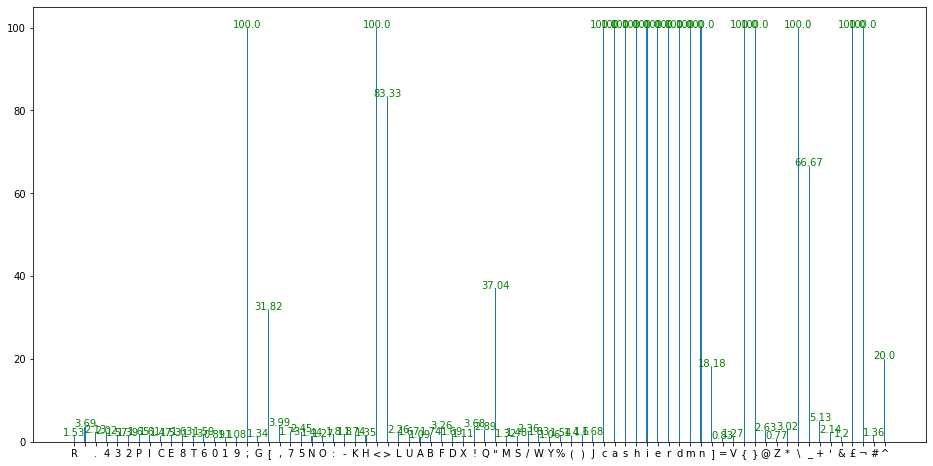

<Figure size 432x288 with 0 Axes>

In [304]:
plt.rcParams['axes.grid'] = False

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

xpos = np.arange(len(bar_target_key))

rects = plt.bar(xpos, bar_target_value, align='center', width=0.1)
plt.xticks(xpos, bar_target_key)

for i, rect in enumerate(rects):
    ax.text(rect.get_x() + rect.get_width() / 2.0,
            1 * rect.get_height(), 
            str(bar_target_value[i]), ha='center', color='green')

# plt.xlabel('aaa')
plt.show()
plt.savefig('result.jpg')